In [6]:
import torch
from math import log
from collections import OrderedDict
from itertools import product

#######################################################################################

D = 2
H = 16
R0 = 0.1
op = 10000
batch = 10
hidden_size = 100
lr = 0.001
lr_Z = 0.01


#######################################################################################


def transfer(state):
    global H, D, batch
    res = [[float(0)] * H * D for i in range(batch)]
    for k in range(0, batch):
        for i in range(0, D):
            res[k][state[k][i] + i * H] = float(1)
    return res


def reward(x):
    global R0, D, H
    f1 = True
    f2 = True
    for d in range(D):
        if not (0.25 < abs(x[d] / (H - 1) - 0.5) <= 0.5): f1 = False
        if not (0.3 < abs(x[d] / (H - 1) - 0.5) < 0.4): f2 = False
    return R0 + 0.5 * f1 + 2 * f2


#######################################################################################

model_DB = torch.nn.Sequential(
    OrderedDict([
        ("linear_1", torch.nn.Linear(D * H, hidden_size)),
        ("activation_1", torch.nn.ReLU()),
        ("linear_2", torch.nn.Linear(hidden_size, D + 2))
    ])
)
optimizer_DB = torch.optim.Adam(
    model_DB.parameters(),
    lr=lr
)


def loss_fn_DB():
    global H, D, batch
    used = [0] * batch
    states = [[0] * D for i in range(batch)]
    ways = [[] for i in range(batch)]
    while True:
        pred = model_DB(torch.tensor(transfer(states)))
        p_Fs = pred[:, 0: -1]
        Fs = pred[:, -1]
        end = True
        for j in range(0, batch):
            if used[j]:
                continue
            end = False
            for i in range(0, D):
                if states[j][i] == H - 1:
                    p_Fs[j][i] = -float("inf")
        if end:
            break
        m = torch.nn.Softmax(dim=1)
        p_Fs = m(p_Fs)
        while True:
            ind = torch.distributions.categorical.Categorical(p_Fs).sample()
            iscorrect = True
            for j in range(0, batch):
                if used[j] or ind[j] == D:
                    continue
                if states[j][ind[j]] == H - 1:
                    iscorrect = False
            if iscorrect == False:
                continue
            for j in range(0, batch):
                if used[j]:
                    continue
                p_B = 0
                for i in range(0, D):
                    if states[j][i] >= 1:
                        p_B += 1
                p_B = max(p_B, 1)
                ways[j].append([Fs[j], torch.log(p_Fs[j][ind[j]]), log(1 / p_B)])
                if ind[j] == D:
                    ways[j].append([log(reward(states[j])), 0, 0])
                    used[j] = True
                else:
                    assert (states[j][ind[j]] != H - 1)
                    states[j][ind[j]] += 1
            break
    loss = 0
    for j in range(batch):
        for i in range(0, len(ways[j]) - 1):
            loss += (ways[j][i][0] + ways[j][i][1] - ways[j][i + 1][0] - ways[j][i + 1][2]) ** 2
    loss /= batch
    return loss, states


#######################################################################################

model_TB_Pfs = torch.nn.Sequential(
    OrderedDict([
        ("linear_1", torch.nn.Linear(D * H, hidden_size)),
        ("activation_1", torch.nn.ReLU()),
        ("linear_2", torch.nn.Linear(hidden_size, D + 1))
    ])
)
optimizer_TB_Pfs = torch.optim.Adam(
    model_TB_Pfs.parameters(),
    lr=lr
)

model_TB_log_Z = torch.nn.Parameter(torch.tensor(0.0, requires_grad=True))
optimizer_TB_log_Z = torch.optim.Adam([model_TB_log_Z], lr_Z)


def loss_fn_TB():
    global H, D, model_TB_log_Z, batch
    used = [0] * batch
    allstate = [[0] * D for i in range(batch)]
    way = [[] for i in range(batch)]
    while True:
        p_Fs = model_TB_Pfs(torch.tensor(transfer(allstate)))
        was = False
        for j in range(0, batch):
            if used[j]:
                continue
            was = True
            for i in range(0, D):
                if allstate[j][i] == H - 1:
                    p_Fs[j][i] = -float("inf")
        if was == False:
            break
        m = torch.nn.Softmax(dim=1)
        p_Fs = m(p_Fs)
        while True:
            ind = torch.distributions.categorical.Categorical(p_Fs).sample()
            iscorrect = True
            for j in range(0, batch):
                if used[j] or ind[j] == D:
                    continue
                if allstate[j][ind[j]] == H - 1:
                    iscorrect = False
            if iscorrect == False:
                continue
            for j in range(0, batch):
                if used[j]:
                    continue
                p_B = 0
                for i in range(0, D):
                    if allstate[j][i] >= 1:
                        p_B += 1
                p_B = max(p_B, 1)
                way[j].append([torch.log(p_Fs[j][ind[j]]), log(1 / p_B)])
                if ind[j] == D:
                    #way[j][-1][1] = 1
                    way[j].append([0, 0])
                    used[j] = True
                else:
                    assert(allstate[j][ind[j]] != H - 1)
                    allstate[j][ind[j]] += 1
            break
    j = 0
    loss = 0
    for state in allstate:
        cur = model_TB_log_Z - log(reward(state))
        for i in range(0, len(way[j]) - 1):
            cur += way[j][i][0] - way[j][i + 1][1]
        cur = cur ** 2
        loss += cur
        j += 1
    loss /= batch
    return loss, allstate


#######################################################################################

rewards = torch.zeros(*[H for i in range(D)])
coord_diap = [range(H) for _ in range(D)]

for coord in product(*coord_diap):
    rewards[tuple(coord)] = reward(torch.tensor(coord))

rewards /= rewards.sum()


def empirical_loss(a, samples=1000):
    counter = torch.zeros(*[H for i in range(D)])
    for i in range(samples):
        counter[tuple(a[i])] += 1

    counter /= counter.sum()

    return (rewards - counter).abs().sum()

In [7]:
import matplotlib.pyplot as plt
import matplotlib

In [8]:
import numpy as np

In [9]:
import matplotlib.animation as animation

In [10]:
visited_DB = []
visited_TB = []

DB_frames = []
TB_frames = []

for i in range(op):
    optimizer_DB.zero_grad()
    x = loss_fn_DB()
    loss_DB = x[0]
    for j in x[1]:
        visited_DB.append(j)
    loss_DB.backward()
    optimizer_DB.step()
    ####
    optimizer_TB_Pfs.zero_grad()
    optimizer_TB_log_Z.zero_grad()
    x = loss_fn_TB()
    loss_TB = x[0]
    for j in x[1]:
        visited_TB.append(j)
    loss_TB.backward()
    optimizer_TB_Pfs.step()
    optimizer_TB_log_Z.step()
    ###
    if i % 100 == 0:
        print(i * batch)
        print(end="DB: ")
        print(empirical_loss(visited_DB[-10000:], len(visited_DB[-10000:])))
        print(end="TB: ")
        print(empirical_loss(visited_TB[-10000:], len(visited_TB[-10000:])))

        samples = len(visited_DB[-10000:])

        counter = torch.zeros(*[H for i in range(D)])
        for i in range(samples):
            counter[tuple(visited_DB[-10000:][i])] += 1

        counter /= counter.sum()

        DB_frames.append(counter)

        counter = torch.zeros(*[H for i in range(D)])
        for i in range(samples):
            counter[tuple(visited_DB[-10000:][i])] += 1

        counter /= counter.sum()

        TB_frames.append(counter)

0
DB: tensor(1.9024)
TB: tensor(1.8872)
1000
DB: tensor(1.5091)
TB: tensor(1.4721)
2000
DB: tensor(1.2996)
TB: tensor(1.3365)
3000
DB: tensor(1.1418)
TB: tensor(1.2071)
4000
DB: tensor(1.0275)
TB: tensor(1.0860)
5000
DB: tensor(0.9539)
TB: tensor(0.9882)
6000
DB: tensor(0.8769)
TB: tensor(0.8898)
7000
DB: tensor(0.8141)
TB: tensor(0.8134)
8000
DB: tensor(0.7611)
TB: tensor(0.7457)
9000
DB: tensor(0.7122)
TB: tensor(0.6890)
10000
DB: tensor(0.6747)
TB: tensor(0.6466)
11000
DB: tensor(0.5971)
TB: tensor(0.5582)
12000
DB: tensor(0.5478)
TB: tensor(0.4911)
13000
DB: tensor(0.5014)
TB: tensor(0.4488)
14000
DB: tensor(0.4625)
TB: tensor(0.4286)
15000
DB: tensor(0.4262)
TB: tensor(0.4042)
16000
DB: tensor(0.3975)
TB: tensor(0.3913)
17000
DB: tensor(0.3675)
TB: tensor(0.3817)
18000
DB: tensor(0.3471)
TB: tensor(0.3690)
19000
DB: tensor(0.3349)
TB: tensor(0.3474)
20000
DB: tensor(0.3241)
TB: tensor(0.3324)
21000
DB: tensor(0.3109)
TB: tensor(0.3205)
22000
DB: tensor(0.2985)
TB: tensor(0.3122)
2

In [11]:
cmap = plt.colormaps['Greens']
levels = matplotlib.ticker.MaxNLocator(nbins=100).tick_values(rewards.min(), rewards.max())
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N)

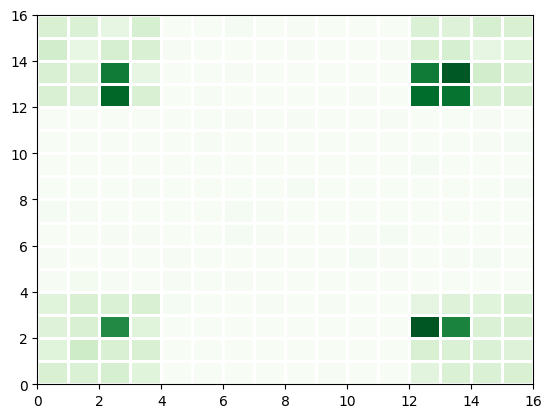

In [ ]:
for i in range(len(TB_frames)):
    plt.pcolormesh(TB_frames[i], cmap=cmap, edgecolors="w", norm=norm)
    plt.savefig(f"D:\Code\sirius december 23\GFlowNets\TB\_img_{i}")

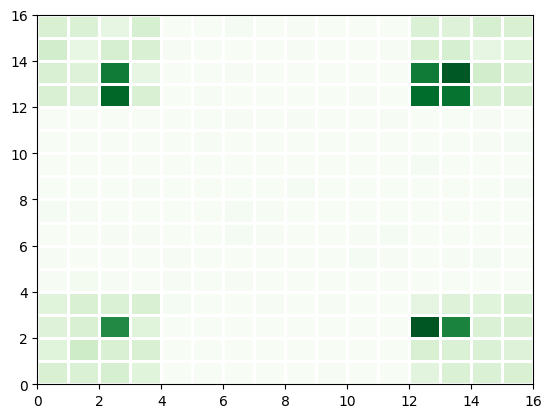

In [101]:
for i in range(len(TB_frames)):
    plt.pcolormesh(DB_frames[i], cmap=cmap, edgecolors="w", norm=norm)
    plt.savefig(f"D:\Code\sirius december 23\GFlowNets\DB\_img_{i}")

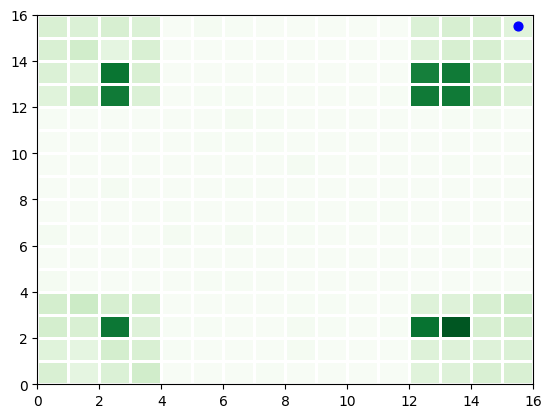

In [12]:
plt.pcolormesh(DB_frames[99], cmap=cmap, edgecolors="w", norm=norm)
plt.scatter(coord[0] + 0.5, coord[1] + 0.5, color='blue', s=40, marker='o')

In [13]:
state = [[0] * D for i in range(5)]
state

[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]

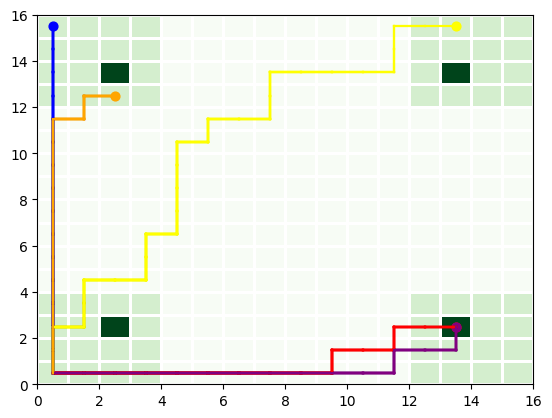

In [39]:
colors = ['blue', 'yellow', 'red', 'purple', 'orange']

batch = 1
state = [[0] * D for i in range(5)]
step = 0
used = [False] * 5
all_show_el = []
while True:
    # print(state)
    step += 1
    plt.pcolormesh(rewards, cmap=cmap, edgecolors="w", norm=norm)
    for pt in range(5):
        while not used[pt]:
            p_Fs = model_TB_Pfs(torch.tensor(transfer([state[pt]])))
            for i in range(0, D):
                if state[pt][i] == H - 1:
                    p_Fs[0][i] = -float("inf")

            m = torch.nn.Softmax(dim=1)
            p_Fs = m(p_Fs)
            ind = torch.distributions.categorical.Categorical(p_Fs).sample()
            # print(ind)
            if ind[0] == 2:
                used[pt] = True
                break
            if state[pt][ind[0]] == H - 1:
                continue
            all_show_el.append([state[pt].copy(), 0, colors[pt]])
            state[pt][ind[0]] += 1
            all_show_el[-1][1] = state[pt].copy()
            plt.scatter(state[pt][0] + 0.5, state[pt][1] + 0.5, color=colors[pt], s=40, marker='o')
            break
        if used[pt]:
            plt.scatter(state[pt][0] + 0.5, state[pt][1] + 0.5, color=colors[pt], s=40, marker='o')
    for i in range(len(all_show_el)):
        # print(all_show_el[i])
        plt.plot([all_show_el[i][0][0] + 0.5, all_show_el[i][1][0] + 0.5], [all_show_el[i][0][1] + 0.5, all_show_el[i][1][1] + 0.5], color=all_show_el[i][2])
    if sum(used) == 5:
        break
    plt.savefig(f"D:\Code\sirius december 23\GFlowNets\Point\_img_{step}")

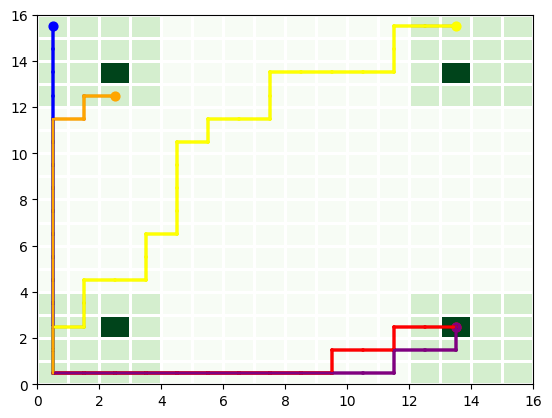

In [43]:
for att in range(25):
    plt.pcolormesh(rewards, cmap=cmap, edgecolors="w", norm=norm)
    for pt in range(5):
        plt.scatter(state[pt][0] + 0.5, state[pt][1] + 0.5, color=colors[pt], s=40, marker='o')
    for i in range(len(all_show_el)):
        # print(all_show_el[i])
        plt.plot([all_show_el[i][0][0] + 0.5, all_show_el[i][1][0] + 0.5], [all_show_el[i][0][1] + 0.5, all_show_el[i][1][1] + 0.5], color=all_show_el[i][2])
    plt.savefig(f"D:\Code\sirius december 23\GFlowNets\Point\_img_{att + 29}")